# Predominant pitch extraction in polyphonic signals

This notebook shows the process of a single audio file of the dataset, here are the sections:

1. [Preparing the audio file](#preparing_audio_file)
2. [Multi Pitch Detection (MPD)](#mpd)
3. [Multi-Pitch Trajectory (MPTC)](#mptc)
4. [Trajectory Segmentation](#trajectory_segmentation)
5. [Showing the results](#showing_results)

In [1]:
import sys
import os
import essentia as ess
import essentia.standard as estd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display as ipd
from scipy import signal

eps = np.finfo(float).eps

sys.path.append('../')
from utils.eval_func import *

SAMPLE_RATE = 44100 # Sample rate
ANALYZE_SOUND_FRAME_SIZE = 2048 # Surce sound analysis frame sizes
HOP_SIZE = 256 # Parameter used by the "FrameGenerator" and "FFT" functions

DATASET_PATH = os.path.join(ROOT_PATH,'data','adc2004_full_set')

OUTPUT_PLOT_FOLDER = "plots"

if not os.path.isdir(OUTPUT_PLOT_FOLDER): os.makedirs(OUTPUT_PLOT_FOLDER)

filename = 'midi1' + '.wav'
audio_path = os.path.join(DATASET_PATH, 'wav', filename)

params = {
            "text.color" : "w",
            "ytick.color" : "w",
            "xtick.color" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w",
            "axes.facecolor" : '2e353e'
        }
plt.rcParams.update(params)


## Preparing the audio file
<a id="preparing_audio_file"></a>

Only one single file is loaded

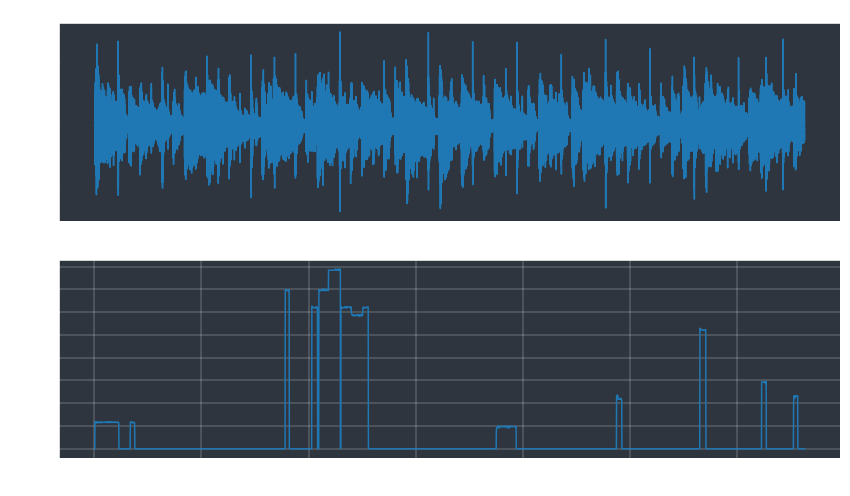

In [2]:
# Loading the audio file and applying an equal loudness filter
audio = estd.EqloudLoader(filename = audio_path, sampleRate = SAMPLE_RATE)()

# Extracting the predominant pitch with Essentia for reference purposes
pitch, confidence = estd.PredominantPitchMelodia(
    frameSize = ANALYZE_SOUND_FRAME_SIZE, 
    hopSize = HOP_SIZE
)(audio)

# Plotting original audio file
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(audio)

# Plotting predominant pitch
ax2 = fig.add_subplot(212)
ax2.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax2.plot(pitch)
ax2.set_title('Pitch reference of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# Saving the plots
plt.savefig(OUTPUT_PLOT_FOLDER + "/reference.png", transparent = True)

# Showing the object to play the file
ipd.display(ipd.Audio(audio, rate=44100))

# Showing the plots
plt.show()

### Multi Pitch Detection (MPD)
<a id="mpd"></a>

- Autocorrelation Based
- All possible maxima of the autocorrelation are considered
- List of frequencies for each frame sorted by the probability of them of being the predominant pitch in that time frame 


In [3]:
def autocorrelation(x_win, fs, minF0 = 100,maxF0 = 1000):
    '''F0 detection on a single frame using autocorrelation
    Parameters
    ----------
    x_win : numpy.array
        Windowed signal frame
    fs,minF0,maxF0 : int
        Sampling rate, minimum and maximum F0 limits
        
    Returns
    -------
    ValAC : numpy.array
    f0 : numpy.array
        Estimated f0 and autocorrelation values for those f0
    ''' 
    f0 = np.array([])
    minT0 = int(fs/maxF0)
    maxT0 = int(fs/minF0)

    Ts = range(minT0,maxT0)
    ValAC = np.array([])
    for k in Ts:
        x_win_shifted = np.hstack((np.zeros(k),x_win[:-k]))
        autoCorr = np.dot(x_win,x_win_shifted)
        ValAC = np.append(ValAC, autoCorr)
        
    f0 = np.divide(fs*np.ones(len(Ts)),Ts)
    return ValAC, f0

In [4]:
def mpd(audio, frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE):
    '''Computes the Multi Pitch Detection (MPD) algorithm for the given signal
    Parameters
    ----------
    audio : numpy.array
        Audio file
        
    Returns
    -------
    frame_freq : numpy.array
        List of sorted frequencies by relevance for each frame
    ''' 
    
    # Getting the window
    window = estd.Windowing()

    # List of frequencies for each frame in a list
    frame_freq = []
    
    # For each frame in the audio file
    for frame in estd.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        
        framelist = []
        frame_win = window(frame)
        
        # Computing the autocorrelation
        AC, f0 = autocorrelation(frame_win, SAMPLE_RATE)
        AC = AC/max(AC)
        
        # Getting the peaks
        peaks,_ = signal.find_peaks(AC)

        tuplelist = [(a,b) for a,b in zip(f0[peaks],AC[peaks])]
        tuplelist.sort(key = lambda x: x[1], reverse = True)

        framelist = [a for a,b in tuplelist]

        frame_freq.append(framelist)
        
    # Returning the value
    return frame_freq
        

In [5]:
def getMostLikely(freq_mat):
    """Returns the most likely frequency for each frame and contructs only one list with them.

    Args:
        freq_mat: numpy.array of sorted frequencies by relevance for each frame
        
    Returns:
        numpy.array of the most likely pitch trajectory.
    """

    most_likely_freq_arr = []

    for frame in freq_mat:

        if frame:
            most_likely_freq_arr.append(frame[0])
        else:
            most_likely_freq_arr.append(0)

    return most_likely_freq_arr

In [6]:
# Computing the Multi Pitch Detection (MPD) algorithm
audio_multi_pitch = mpd(audio)

# Creating an array for the most likely frequency for each frame
most_likely = getMostLikely(audio_multi_pitch)

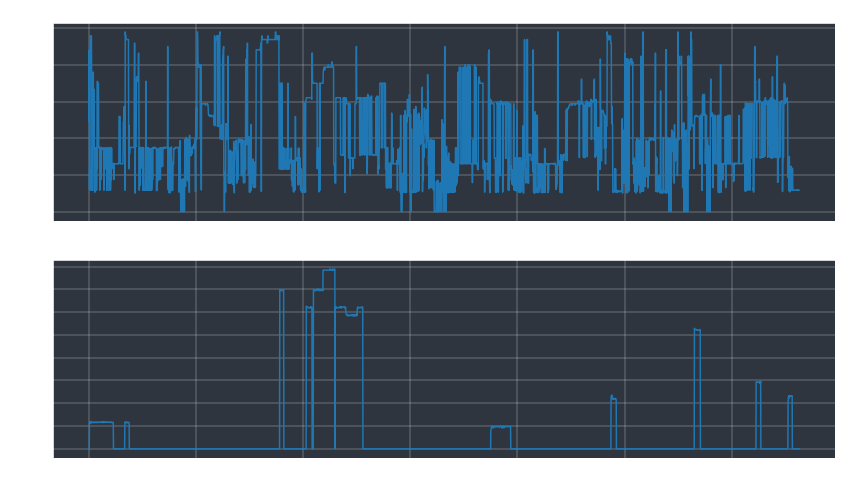

In [7]:
# Plotting original audio file
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax1.set_title('Pitch prediction of ' + filename)
ax1.set_ylabel('Freqs in Hz')
ax1.plot(most_likely)

# Plotting predominant pitch
ax2 = fig.add_subplot(212)
ax2.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax2.plot(pitch)
ax2.set_title('Essentia pitch reference of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Frames')

# Saving the plots
plt.savefig(OUTPUT_PLOT_FOLDER + "/mpd.png", transparent = True)

# Showing the object to play the file
ipd.display(ipd.Audio(audio, rate=44100))

# Showing the plots
plt.show()

### Multi-Pitch Trajectory (MPTC)
<a id="mptc"></a>

- Still in progress
- For now, the pitch with the best autocorrelation in each frame is used.
- In the future, octave correction between frames and harmonic correction in the same frame will be implemented here.


In [8]:
def octaveCorrection(freq_arr, tol_percent=TOL_PERCENT):
    """Corrects errors of an octave shift from frame to frame.
    
    Args:
        freq_arr: numpy.array of the pitch trajectory
        tol_percent: Tolerance percentage allowed as error when detecting octaves

    Returns:
        freq_arr: numpy.array of the corrected pitch trajectory
    """

    if tol_percent > 100:
        raise ValueError("tol_percent music be 0 < tol_percent <= 100")
    elif tol_percent <= 0:
        raise ValueError("tol_percent music be 0 < tol_percent <= 100")

    octave_ratio = 2
    inverse_octave_ratio = 1/octave_ratio
    tolerance = tol_percent/100

    for i, freq in enumerate(freq_arr):
        if i < len(freq_arr)-1:
            if freq_arr[i+1] == 0: ratio = 0 
            else: ratio = freq/freq_arr[i+1]
            if (1-tolerance)*octave_ratio < ratio < (1+tolerance)*octave_ratio:
                freq_arr[i+1] = octave_ratio * freq_arr[i+1]
            elif (1-tolerance)*inverse_octave_ratio < ratio < (1+tolerance)*inverse_octave_ratio:
                freq_arr[i+1] = freq_arr[i+1] / octave_ratio

    return freq_arr

In [9]:
def framesReduction(audio_multi_pitch):
    for i,frame in enumerate(audio_multi_pitch):
        upper = min(3,len(frame))
        audio_multi_pitch[i] = frame[:upper]
    
    return audio_multi_pitch

In [10]:
def mptc(audio_multi_pitch):
    '''Computes the Multi Pitch Trajection (MPTC) algorithm for the given signal
    Parameters
    ----------
    audio_multi_pitch : numpy.array
        List of sorted frequencies by relevance for each frame
        
    Returns
    -------
    freq_arr : numpy.array
        Corrected pitch trajectory
    ''' 
    
    # FRAME LENGTH REDUCTION
    audio_multi_pitch = framesReduction(audio_multi_pitch)
    
    # HARMONIC DELETION PER FRAME
    #audio_multi_pitch = harmonicDeletion(audio_multi_pitch)
    
    #GET THE MOST LIKELY FREQUENCY VALUE
    most_likely_freq_arr = getMostLikely(audio_multi_pitch)
    
    original_freq_arr = most_likely_freq_arr.copy()
    
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(311)
    ax1.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
    ax1.set_title('original_freq_arr')
    ax1.set_ylabel('Freqs in Hz')
    ax1.plot(original_freq_arr)
    #ax1.stem(original_freq_arr[2300:2400])
    
    # OCTAVE CORRECTION
    freq_arr = octaveCorrection(most_likely_freq_arr)
    
    print("Are equal? ", np.array_equiv(original_freq_arr, freq_arr))
    
    ax2 = fig.add_subplot(312)
    ax2.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
    ax2.set_title('freq_arr_mod')
    ax2.set_ylabel('Freqs in Hz')
    ax2.plot(freq_arr)
    #ax2.stem(freq_arr[2300:2400])
    
    ax3 = fig.add_subplot(313)
    ax3.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
    ax3.set_title('Essentia pitch reference of ' + filename)
    ax3.set_ylabel('Freqs in Hz')
    ax3.set_xlabel('Frames')
    ax3.plot(pitch)
    #ax3.stem(pitch[2300:2400])
    
    return freq_arr
        

Are equal?  False


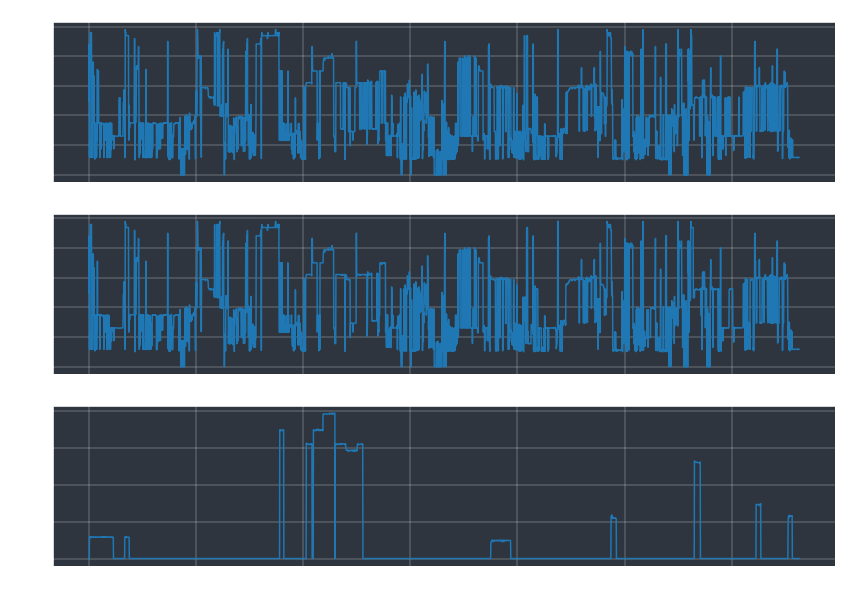

In [11]:
# Computing the Multi-Pitch Trajectory (MPTC) algorithm
freq_arr = mptc(audio_multi_pitch)

### Trajectory Segmentation
<a id="trajectory_segmentation"></a>

- Creating a set of different masks that decide whether the main pitch line is playing or not
- Right now, the masks that have been applied are: 
    - Energy envelope per frame
    - Frequency (un-quantised midi values for linearity of the system) derivative per frame
- Mask the frequency array


In [12]:
def compute_energy_mask(audio, energy_threshold = 0.1, frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE):
    '''Computes the energy per frame of the signal and generates a mask array for the given signal
    Parameters
    ----------
    signal : numpy.array
        Audio file
        
    Returns
    -------
    frame_freq : numpy.array
        List of sorted frequencies by relevance for each frame
    ''' 
    
    # Getting the window
    window = estd.Windowing()
    
    # Energy array
    energy = []
    
    # For each frame in the audio file
    for frame in estd.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):

        frame_win = window(frame)

        energy.append(np.sum(frame_win**2) / len(frame))

    energy = np.array(energy)

    energy = np.convolve(energy, signal.get_window('triang',50), mode = 'same')

    energy = energy / np.max(energy)
    
    # Computing the energy mask
    energy[energy < energy_threshold] = 0
    energy[energy >= energy_threshold] = 1
    
    # Returning the energy mask
    return energy


In [25]:
def compute_freq_diff_mask(freq_arr):
    '''Computes the frequency derivative of a frequency array and generates a mask array for the given signal
    Parameters
    ----------
    freq_arr : numpy.array
        Frequency array
        
    Returns
    -------
    midi_diff_val_mask : numpy.array
        Frequency derivative mask
    ''' 
    
    freq_arr = np.clip(freq_arr, a_min=8.175, a_max=12543.854)
    midi_val = np.log2(freq_arr/440.0) * 12 + 69

    midi_th = 0.1

    midi_diff = abs(np.diff(midi_val))
    midi_diff = np.append(midi_diff,0)

    midi_diff = midi_diff / np.max(midi_diff)

    midi_diff_mask = midi_diff.copy()

    midi_diff_mask[midi_diff_mask < midi_th] = 0
    midi_diff_mask[midi_diff_mask >= midi_th] = 1

    midi_diff_val_mask = np.convolve(midi_diff_mask, signal.get_window('hann',60), mode = 'same')

    midi_diff_val_mask = midi_diff_val_mask / np.max(midi_diff_val_mask)

    midi_diff_val_mask[midi_diff_val_mask < midi_th] = 0
    midi_diff_val_mask[midi_diff_val_mask >= midi_th] = 1

    midi_diff_val_mask = 1 - midi_diff_val_mask
              
    # Returning the frequency derivative mask
    return midi_diff_val_mask


In [26]:
def trajectory_segmentation(audio, freq_arr, frameSize = ANALYZE_SOUND_FRAME_SIZE, hopSize = HOP_SIZE):
    '''Computes the trakectory segmentation algorithm for the given signal
    Parameters
    ----------
    audio : numpy.array
        Audio file
        
    freq_arr : numpy.array
        Array of the most likely frequency for each frame
        
    Returns
    -------
    frame_freq : numpy.array
        List of sorted frequencies by relevance for each frame
    ''' 
    
    # Computing the energy mask
    energy_mask = compute_energy_mask(audio)
    
    # Computing the frequency derivative mask
    freq_diff_mask = compute_freq_diff_mask(freq_arr)
    
    # Applying the masks to the frequency array
    freq_arr_masked = freq_arr * energy_mask * freq_diff_mask
    
    # Returning the masked frequency array
    return freq_arr_masked, energy_mask, freq_diff_mask


In [27]:
# Computing the Trajectory Segmentation algorithm
freq_arr_masked, energy_mask, freq_diff_mask = trajectory_segmentation(audio, freq_arr)

### Showing the results
<a id="showing_results"></a>

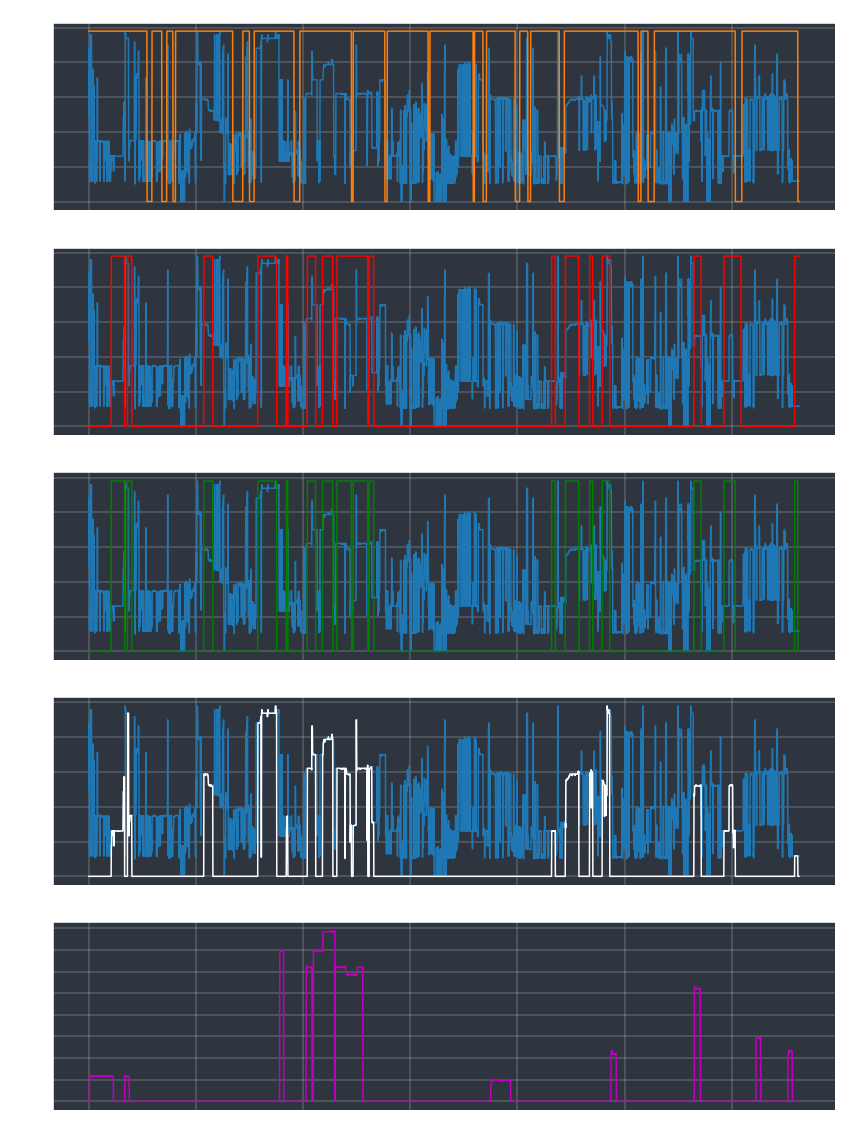

In [28]:
# Plotting the energy mask
fig = plt.figure(figsize=(14, 20))
ax1 = fig.add_subplot(511)
ax1.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax1.set_title('Energy mask')
ax1.set_ylabel('Freqs in Hz')
ax1.plot(freq_arr)
ax1.plot(energy_mask * np.max(freq_arr))

# Plotting the derivative mask
ax2 = fig.add_subplot(512)
ax2.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax2.set_title('Derivative mask')
ax2.set_ylabel('Freqs in Hz')
ax2.plot(freq_arr)
ax2.plot(freq_diff_mask * np.max(freq_arr), 'r')

# Plotting the full
ax3 = fig.add_subplot(513)
ax3.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax3.set_title('Full mask')
ax3.set_ylabel('Freqs in Hz')
ax3.plot(freq_arr)
ax3.plot(energy_mask * freq_diff_mask * np.max(freq_arr), 'g')

# Plotting the masked pitch
ax4 = fig.add_subplot(514)
ax4.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax4.set_title('Masked pitch')
ax4.set_ylabel('Freqs in Hz')
ax4.plot(freq_arr)
ax4.plot(freq_arr_masked, 'w')

# Plotting the Essentia reference
ax5 = fig.add_subplot(515)
ax5.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
ax5.set_title('Essentia reference')
ax5.set_ylabel('Freqs in Hz')
ax5.set_xlabel('Frame')
ax5.plot(pitch, 'm')

# Saving the plots
plt.savefig(OUTPUT_PLOT_FOLDER + "/trajectory_segmentation.png", transparent = True)

# Showing the object to play the file
ipd.display(ipd.Audio(audio, rate=44100))

# Showing the plots
plt.show()

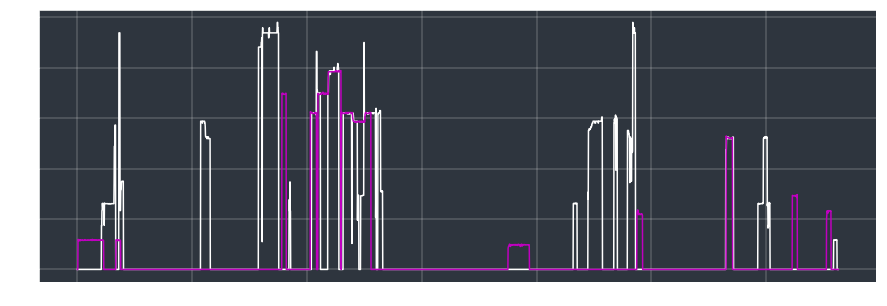

In [29]:
plt.figure(figsize=(15,5))
plt.plot(freq_arr_masked, 'w')
plt.plot(pitch, 'm')
plt.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
plt.show()

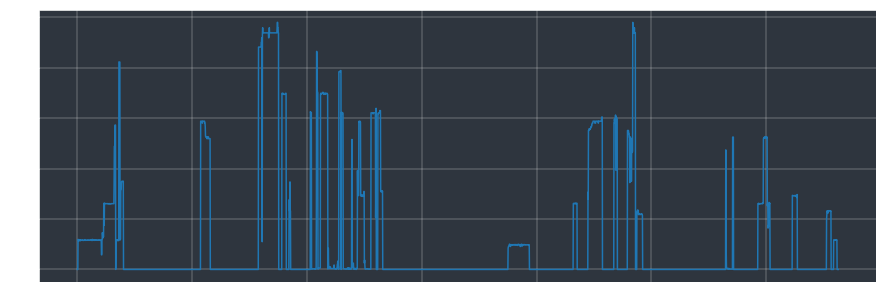

In [30]:
plt.figure(figsize=(15,5))
plt.grid(b = True, axis = 'both', color = 'w', linestyle = '-', linewidth = 0.3)
plt.plot(abs(pitch-freq_arr_masked))
plt.show()